# COVID-19 Data Analytics
### Annie Bryan

#### Imports

In [1]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from datetime import datetime, timedelta

#### Obtaining data

In [2]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
df_raw = pd.read_csv(url)
df = df_raw.iloc[:,np.r_[6,11:len(df_raw.columns)]]

#### Cleaning data

In [3]:
# aggregate by state
aggregated_df = df.groupby(by="Province_State").sum().reset_index()
states = set(pd.read_csv("https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv")["State"])
is_state = aggregated_df["Province_State"].isin(states)
df_by_state = aggregated_df[is_state].reset_index().iloc[:,1:]

#### Exploring data

In [4]:
# new daily cases
states = df_by_state.iloc[:,0]
daily_data = df_by_state.iloc[:,1:len(df_by_state.columns)].diff(axis=1).iloc[:,1:len(df_by_state.columns)].applymap(lambda i: int(i))
daily_cases = pd.concat([states, daily_data], axis=1)

In [5]:
def df_n_day_avg(df, n):
    states = df.iloc[:,0]
    data = df.rolling(n, axis=1, center=True).mean().iloc[:,int((n-1)/2):len(df.columns)-int((n+1)/2)].applymap(lambda i: int(i))
    return pd.concat([states, data], axis=1)

In [6]:
# 3 day average
df_3_day_avg = df_n_day_avg(daily_cases, 3)

# 5 day average
df_5_day_avg = df_n_day_avg(daily_cases, 5)

# 7 day average
df_7_day_avg = df_n_day_avg(daily_cases, 7)

In [7]:
def series_n_day_avg(series, n):
    return series.rolling(n, center=True).mean().iloc[int((n-1)/2):len(series)-int((n-1)/2)].apply(lambda i: int(i))

In [8]:
# aggregate across country
us_daily_cases = daily_cases.sum()[1:]

# 3 day average
series_3_day_avg = series_n_day_avg(us_daily_cases, 3)

# 5 day average
series_5_day_avg = series_n_day_avg(us_daily_cases, 5)

# 7 day average
series_7_day_avg = series_n_day_avg(us_daily_cases, 7)

#### Visualizing data

/Users/anniebryan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error two minor releases later


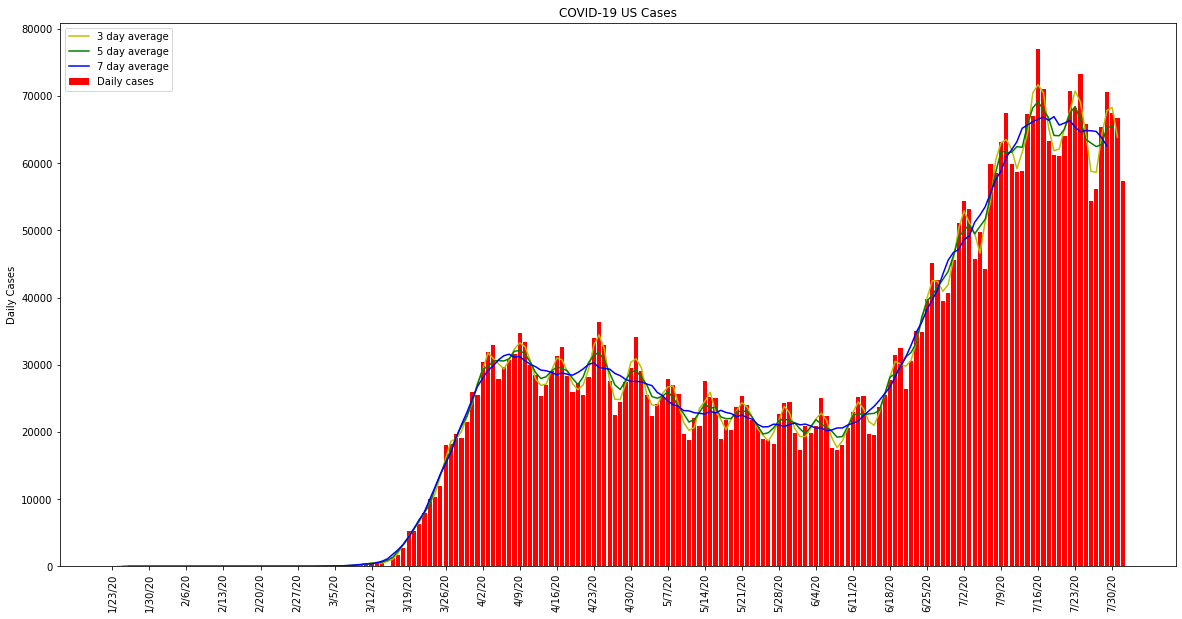

In [9]:
# initialize plot
plt.figure(figsize=(20,10))

# plot daily cases as bar graph
dates = us_daily_cases.index
cases = list(us_daily_cases)
plt.bar(dates, cases, color='r')

# plot 3 day average as line graph
dates_3_day_avg = series_3_day_avg.index
cases_3_day_avg = list(series_3_day_avg)
plt.plot(dates_3_day_avg, cases_3_day_avg, color='y')

# plot 5 day average as line graph
dates_5_day_avg = series_5_day_avg.index
cases_5_day_avg = list(series_5_day_avg)
plt.plot(dates_5_day_avg, cases_5_day_avg, color='g')

# plot 7 day average as line graph
dates_7_day_avg = series_7_day_avg.index
cases_7_day_avg = list(series_7_day_avg)
plt.plot(dates_7_day_avg, cases_7_day_avg, color='b')

# define x-axis ticks
ticks = list(us_daily_cases.index)[::7]
plt.xticks(ticks, rotation=90)

# define title and labels
plt.title("COVID-19 US Cases")
plt.ylabel('Daily Cases')
plt.legend(["3 day average", "5 day average", "7 day average", "Daily cases"])

# save to png
filename = "us-covid-cases.png"
plt.savefig(filename, bbox_inches = 'tight', optimize=True)

# plot chart below
plt.show()

In [10]:
# get local maxima
maxima = argrelextrema(np.array(cases_7_day_avg), np.greater)

# get local minima
minima = argrelextrema(np.array(cases_7_day_avg), np.less)

Based on visual observation of the plotted data along with the maxima and minima values, I was able to divide the time series into 4 groups.
<ul>
    <li>the initial rise of the virus</li>
    <li>the first decline</li>
    <li>the second wave</li>
    <li>the second decline</li>
</ul>
I will analyze these 4 groups separately in order to more accurately model the data with best-fit curves.

In [14]:
# initial rise (feb 25 - apr 7)
initial_rise_dates = dates_7_day_avg[30:73]
initial_rise_cases = cases_7_day_avg[30:73]

# first decline (apr 7 - june 6)
first_decline_dates = dates_7_day_avg[72:133]
first_decline_cases = cases_7_day_avg[72:133]

# second wave (june 6 - july 19)
second_wave_dates = dates_7_day_avg[132:176]
second_wave_cases = cases_7_day_avg[132:176]

# second decline (july 19 - present)
second_decline_dates = dates_7_day_avg[160:]
second_decline_cases = cases_7_day_avg[160:]

In [15]:
# defining functions to represent data

def logistic(x, yo, k, r):
    return (k*yo)/(yo + (k-yo)*np.exp(-r*x))
    
def exponential(x, a, b):
    return a*np.exp(b*x)
    
def parabola(x, a, b, c):
    return a*x**2 + b*x + c
    
def linear(x, a, b):
    return a*x + b

In [16]:
def get_best_fit(data, best_fit_fn):
    popt, pcov = curve_fit(best_fit_fn, list(range(len(data))), data)
    best_fit_vals = [best_fit_fn(t, *popt) for t in range(len(data))]
    
    residuals = [d - b for d, b in zip(data, best_fit_vals)]
    ss_res = np.sum([i**2 for i in residuals])
    ss_tot = np.sum((data-np.mean(data))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    return best_fit_vals, r_squared

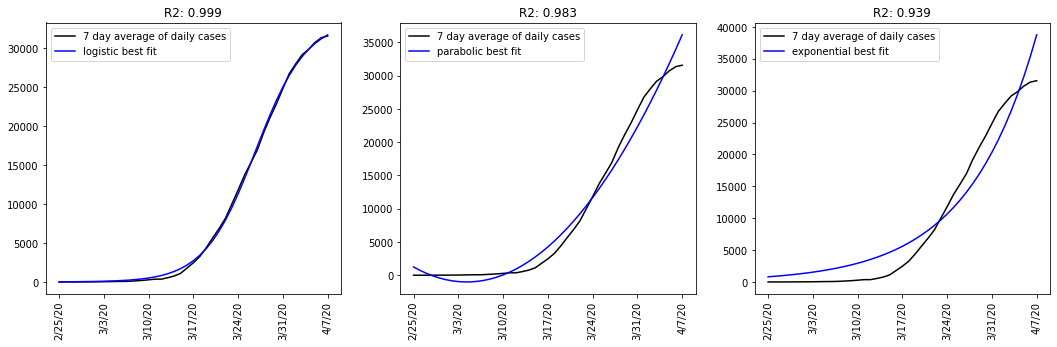

In [17]:
# Initial Rise

plt.rcParams['figure.figsize'] = [18, 5]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

best_fit_vals, r_squared = get_best_fit(initial_rise_cases, logistic)
ax1.plot(initial_rise_dates, initial_rise_cases, color='k')
ax1.plot(initial_rise_dates, best_fit_vals, color='b')

ticks = list(initial_rise_dates)[::7]
ax1.set_xticks(ticks)
ax1.set_xticklabels(ticks, rotation=90)

ax1.legend(["7 day average of daily cases", "logistic best fit"])
ax1.set_title("R2: " + str(format(r_squared, '.3f')))

best_fit_vals, r_squared = get_best_fit(initial_rise_cases, parabola)
ax2.plot(initial_rise_dates, initial_rise_cases, color='k')
ax2.plot(initial_rise_dates, best_fit_vals, color='b')

ticks = list(initial_rise_dates)[::7]
ax2.set_xticks(ticks)
ax2.set_xticklabels(ticks, rotation=90)

ax2.legend(["7 day average of daily cases", "parabolic best fit"])
ax2.set_title("R2: " + str(format(r_squared, '.3f')))

best_fit_vals, r_squared = get_best_fit(initial_rise_cases, exponential)
ax3.plot(initial_rise_dates, initial_rise_cases, color='k')
ax3.plot(initial_rise_dates, best_fit_vals, color='b')

ticks = list(initial_rise_dates)[::7]
ax3.set_xticks(ticks)
ax3.set_xticklabels(ticks, rotation=90)

ax3.legend(["7 day average of daily cases", "exponential best fit"])
ax3.set_title("R2: " + str(format(r_squared, '.3f')))

plt.show()

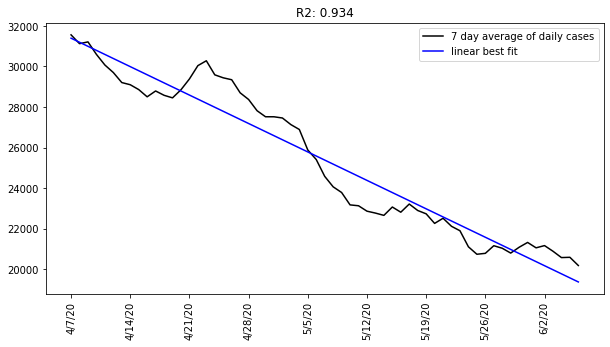

In [18]:
# First Decline

plt.rcParams['figure.figsize'] = [10, 5]

fig, ax1 = plt.subplots(ncols=1)

best_fit_vals, r_squared = get_best_fit(first_decline_cases, linear)
ax1.plot(first_decline_dates, first_decline_cases, color='k')
ax1.plot(first_decline_dates, best_fit_vals, color='b')

ax1.legend(["7 day average of daily cases", "linear best fit"])
ax1.set_title("R2: " + str(format(r_squared, '.3f')))

ticks = list(first_decline_dates)[::7]
ax1.set_xticks(ticks)
ax1.set_xticklabels(ticks, rotation=90)

plt.show()

/Users/anniebryan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


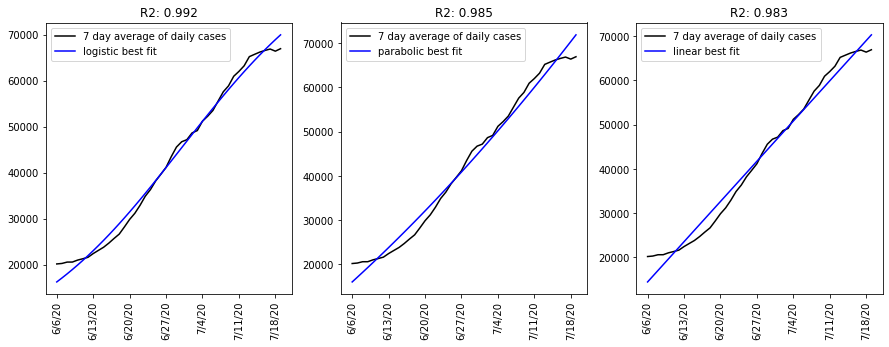

In [19]:
# Second Wave

plt.rcParams['figure.figsize'] = [15, 5]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

best_fit_vals, r_squared = get_best_fit(second_wave_cases, logistic)
ax1.plot(second_wave_dates, second_wave_cases, color='k')
ax1.plot(second_wave_dates, best_fit_vals, color='b')

ax1.legend(["7 day average of daily cases", "logistic best fit"])
ax1.set_title("R2: " + str(format(r_squared, '.3f')))

best_fit_vals, r_squared = get_best_fit(second_wave_cases, parabola)
ax2.plot(second_wave_dates, second_wave_cases, color='k')
ax2.plot(second_wave_dates, best_fit_vals, color='b')

ax2.legend(["7 day average of daily cases", "parabolic best fit"])
ax2.set_title("R2: " + str(format(r_squared, '.3f')))

best_fit_vals, r_squared = get_best_fit(second_wave_cases, linear)
ax3.plot(second_wave_dates, second_wave_cases, color='k')
ax3.plot(second_wave_dates, best_fit_vals, color='b')

ax3.legend(["7 day average of daily cases", "linear best fit"])
ax3.set_title("R2: " + str(format(r_squared, '.3f')))

ticks = list(second_wave_dates)[::7]
ax1.set_xticks(ticks)
ax1.set_xticklabels(ticks, rotation=90)
ax2.set_xticks(ticks)
ax2.set_xticklabels(ticks, rotation=90)
ax3.set_xticks(ticks)
ax3.set_xticklabels(ticks, rotation=90)

plt.show()

### Analyzing the effects of a state-mandated stay-at-home order

**Null Hypothesis:** Stay-at-home policies do not slow the rate of spread of the COVID-19 virus.<br>
**Alternative Hypothesis:** Stay-at-home policies slow the rate of spread of the COVID-19 virus.<br>
**Significance Level:** $\alpha$ = 0.05

States that did not implement a stay at home order:
<ul>
    <li>Arkansas</li>
    <li>Iowa</li>
    <li>Nebraska</li>
    <li>North Dakota</li>
    <li>South Dakota</li>
</ul>

#### \#TODO calculate each of the following
growth rate before policy <br>
growth rate during policy <br>
growth rate after policy <br>

In [20]:
# reading in CSV file as pandas dataframe
stay_at_home_df = pd.read_csv(open('stay-at-home-orders.csv'))
states = set(stay_at_home_df['State'])
stay_at_home_df

,State,Date Enacted,Date Lifted
0,Alabama,4/4/20,4/30/20
1,Alaska,3/28/20,4/24/20
2,Arizona,3/31/20,5/15/20
3,California,3/19/20,5/7/20
4,Colorado,3/26/20,4/27/20
5,Connecticut,3/23/20,5/20/20
6,Delaware,3/24/20,6/1/20
7,District of Columbia,4/1/20,5/29/20
8,Florida,4/3/20,5/4/20
9,Georgia,4/3/20,4/24/20


In [21]:
is_state = df_by_state["Province_State"].isin(states)
df = df_by_state[is_state].reset_index().iloc[:,1:]
df

,Province_State,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20
0,Alabama,0,0,0,0,0,0,0,0,0,...,74212,76005,78130,79294,81115,82366,83782,85762,87723,89349
1,Alaska,0,0,0,0,0,0,0,0,0,...,2193,2249,2339,2525,2623,2730,2798,2879,2990,3136
2,Arizona,0,0,0,0,1,1,1,1,1,...,152944,156301,160041,162014,163827,165934,168273,170798,174010,177002
3,California,0,0,0,0,2,2,2,2,2,...,430773,440185,446452,452288,458121,470762,484913,492934,500556,506613
4,Colorado,0,0,0,0,0,0,0,0,0,...,42295,42962,43771,44318,44547,45296,45778,46186,46791,47249
5,Connecticut,0,0,0,0,0,0,0,0,0,...,48232,48776,48776,48776,48983,49077,49540,49670,49810,49810
6,Delaware,0,0,0,0,0,0,0,0,0,...,13924,14202,14175,14290,14406,14476,14602,14689,14788,14877
7,District of Columbia,0,0,0,0,0,0,0,0,0,...,11571,11649,11717,11780,11858,11945,11999,12057,12057,12057
8,Florida,0,0,0,0,0,0,0,0,0,...,389868,402312,414511,423855,432747,441977,451423,461379,470386,480028
9,Georgia,0,0,0,0,0,0,0,0,0,...,156607,161420,165188,167953,170843,175052,178323,182286,186352,190012


In [22]:
def get_enacted_dates(state):
    dates = stay_at_home_df.loc[stay_at_home_df["State"]==state, ["Date Enacted", "Date Lifted"]].values.flatten().tolist()
    return dates

def get_all_state_data(state):
    is_state = df_7_day_avg["Province_State"]==state
    all_state_data = df_7_day_avg[is_state].reset_index().iloc[:,1:]
    return all_state_data

def get_data_before_enacted(state):
    all_dates = list(df_7_day_avg.columns[1:])
    date_enacted = get_enacted_dates(state)[0]
    dates_before_enacted = all_dates[:all_dates.index(date_enacted)+1]
    
    all_state_data = get_all_state_data(state)
    state_data_before_enacted = all_state_data[dates_before_enacted].values.flatten().tolist()
    first_non_zero_day = next((index for index,value in enumerate(state_data_before_enacted) if value != 0), None)
    return state_data_before_enacted[first_non_zero_day:]

def get_data_while_enacted(state):
    all_dates = list(df_7_day_avg.columns[1:])
    date_enacted, date_lifted = get_enacted_dates(state)
    dates_while_enacted = all_dates[all_dates.index(date_enacted):all_dates.index(date_lifted)+1]
    
    all_state_data = get_all_state_data(state)
    state_data_while_enacted = all_state_data[dates_while_enacted].values.flatten().tolist()
    return state_data_while_enacted

def get_data_after_lifted(state):
    all_dates = list(df_7_day_avg.columns[1:])
    date_lifted = get_enacted_dates(state)[1]
    dates_after_lifted = all_dates[all_dates.index(date_lifted):]
    
    all_state_data = get_all_state_data(state)
    state_data_after_lifted = all_state_data[dates_after_lifted].values.flatten().tolist()
    return state_data_after_lifted